In [2]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, when, concat, lit
from pyspark.sql.types import TimestampType
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
    .appName("green preprocessing") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.parquet.cacheMetadata", "true") \
    .config("spark.sql.session.timeZone", "Etc/UTC") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

your 131072x1 screen size is bogus. expect trouble
23/09/14 03:07:37 WARN Utils: Your hostname, NivethanAsus resolves to a loopback address: 127.0.1.1; using 172.20.150.32 instead (on interface eth0)
23/09/14 03:07:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/14 03:07:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/09/14 03:07:40 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/09/14 03:07:40 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
23/09/14 03:07:40 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
23/09/14 03:07:40 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


In [3]:
path1 = "../../../data/insights/joined.parquet"
df = spark.read.parquet(path1)
df.show(5)
df.printSchema()
print("length:",df.count())

df_pandas = df.toPandas()

+------------+--------------------+-------------+---------+----------------------------------+-------------------+----------------------------------+--------------------------+----------------+---------------------+-------------------+--------------------------------+---------------------------+------------------+---------------------------------+--------------------+
|merchant_abn|                name|revenue_level|take_rate|average_merchant_fraud_probability|number_of_consumers|average_consumer_fraud_probability|number_of_repeat_consumers|number_of_orders|average_cost_of_order|number_of_postcodes|avg_total_weekly_personal_income|avg_total_weekly_fam_income|    avg_median_age|avg_num_of_consumers_per_postcode|merchant_description|
+------------+--------------------+-------------+---------+----------------------------------+-------------------+----------------------------------+--------------------------+----------------+---------------------+-------------------+-----------------------

Summary Statistics for average_consumer_fraud_probability:

count    4026.000000
mean        1.023902
std         3.861449
min         0.000000
25%         0.023131
50%         0.054687
75%         0.210249
max        94.703400
Name: average_consumer_fraud_probability, dtype: float64

--------------------------------------------------



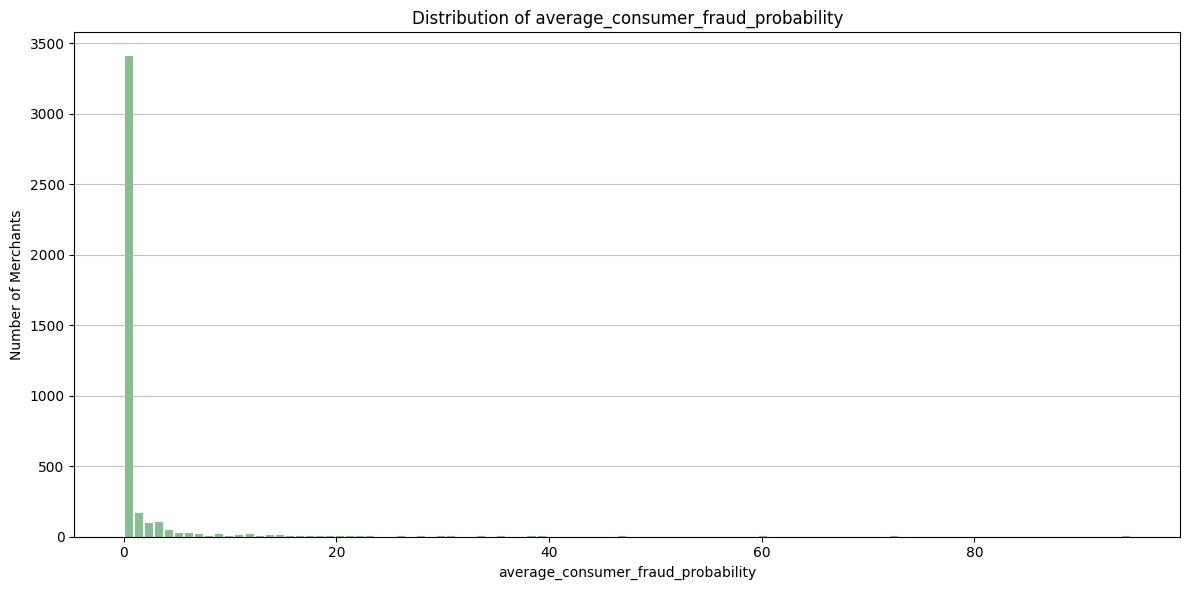

Summary Statistics for avg_median_age:

count    4026.000000
mean       43.112349
std         0.991092
min        26.000000
25%        42.913605
50%        43.107035
75%        43.300379
max        55.000000
Name: avg_median_age, dtype: float64

--------------------------------------------------



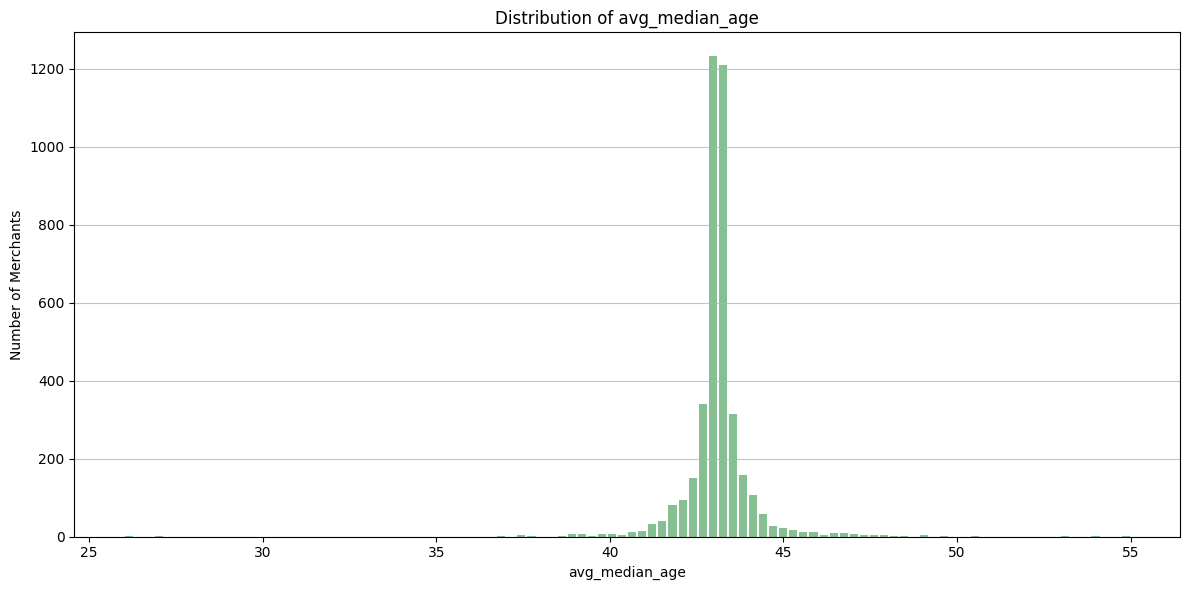

Summary Statistics for avg_total_weekly_personal_income:

count    4026.000000
mean      789.579167
std        30.273343
min       471.000000
25%       782.828468
50%       790.159310
75%       796.630394
max      1165.900000
Name: avg_total_weekly_personal_income, dtype: float64

--------------------------------------------------



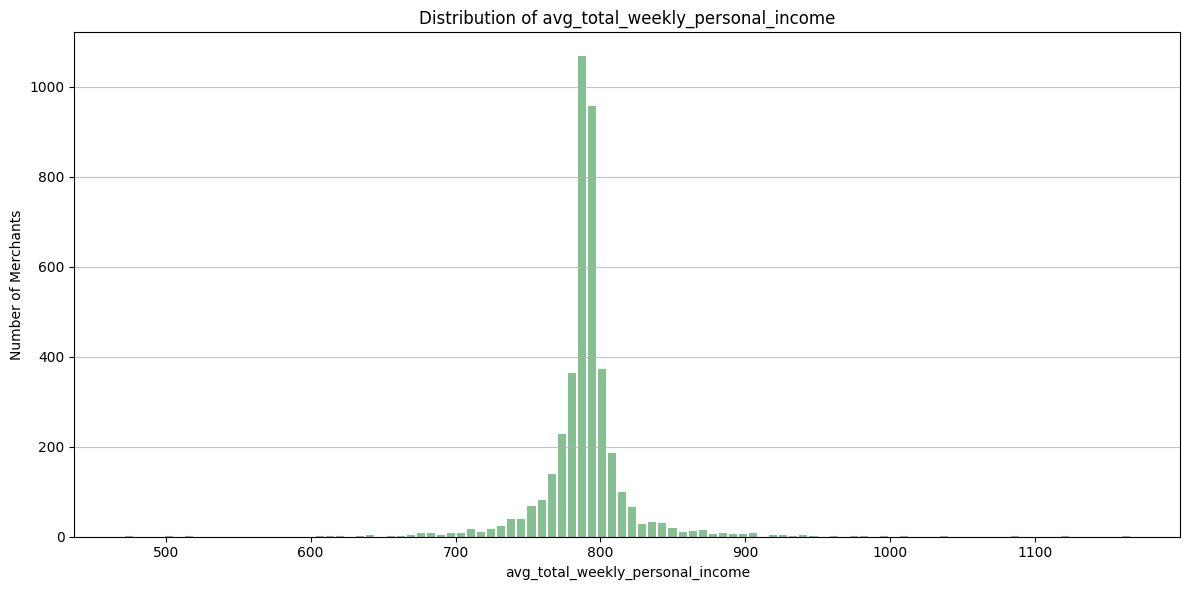

Summary Statistics for take_rate:

count    4026.000000
mean        4.397576
std         1.782595
min         0.100000
25%         2.970000
50%         4.500000
75%         6.030000
max         7.000000
Name: take_rate, dtype: float64

--------------------------------------------------



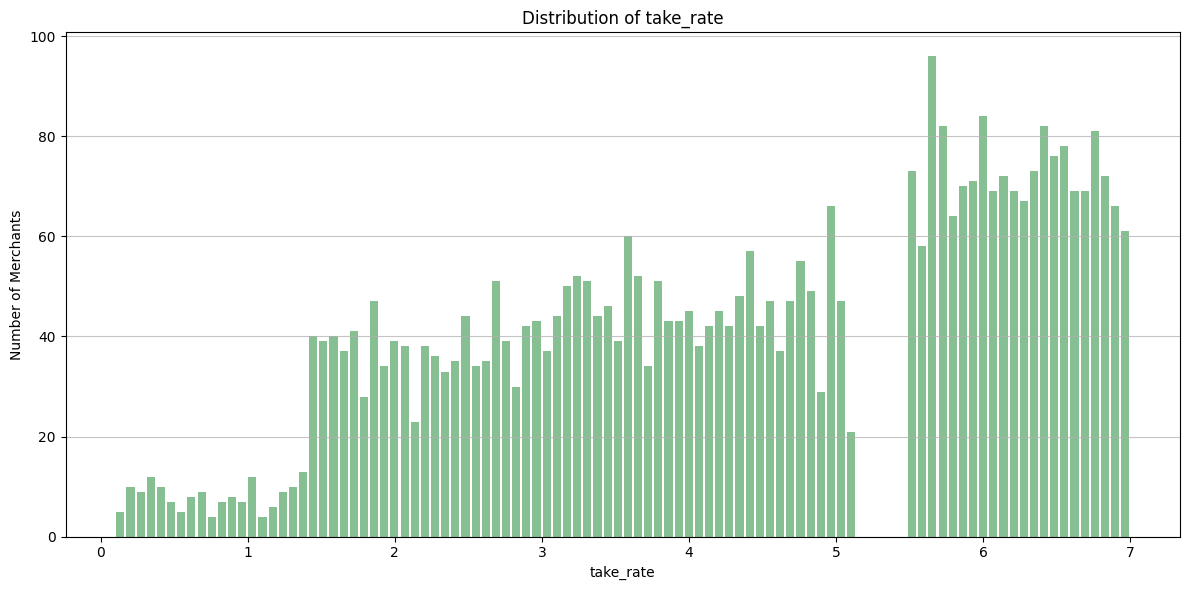

Summary Statistics for average_cost_of_order:

count     4026.000000
mean      1162.394858
std       2972.212606
min          7.579026
25%        118.295487
50%        317.551494
75%        841.489967
max      51876.640000
Name: average_cost_of_order, dtype: float64

--------------------------------------------------



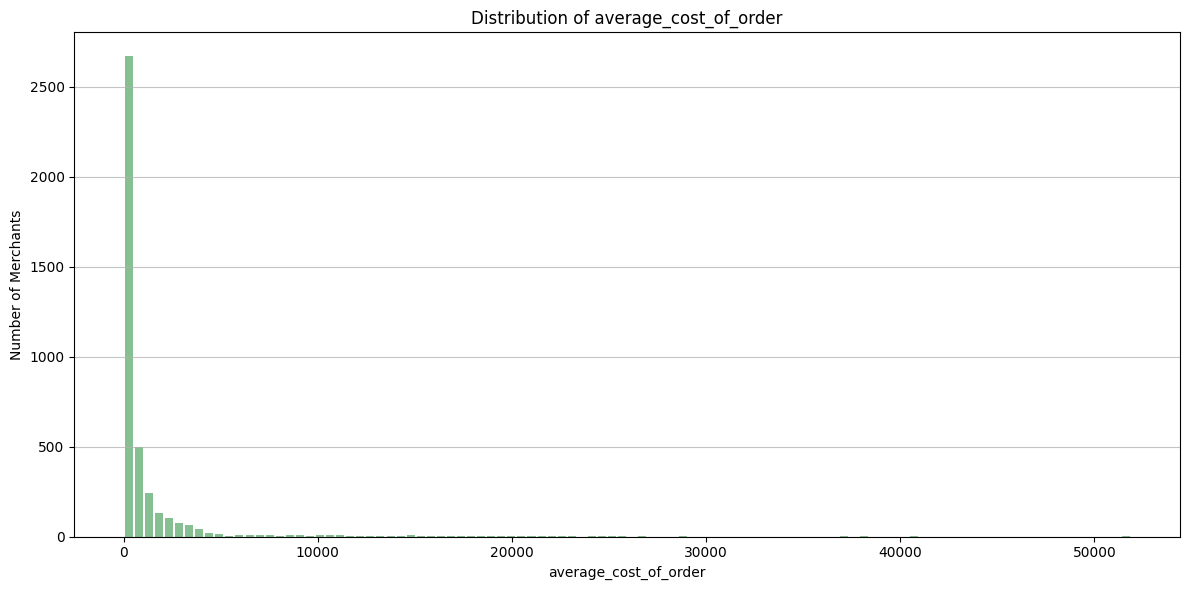

Summary Statistics for number_of_orders:

count      4026.000000
mean       2824.824888
std       11816.655769
min           1.000000
25%          78.250000
50%         352.000000
75%        1718.500000
max      241547.000000
Name: number_of_orders, dtype: float64

--------------------------------------------------



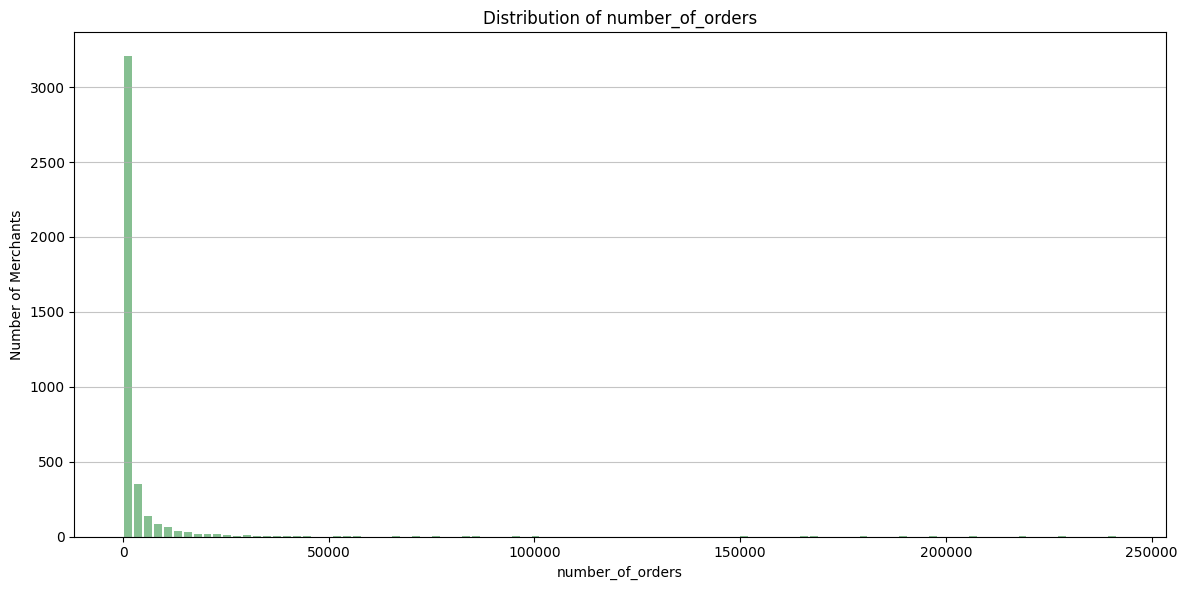

Summary Statistics for number_of_consumers:

count     4026.000000
mean      1691.663189
std       3236.959538
min          1.000000
25%         78.250000
50%        349.000000
75%       1643.500000
max      20115.000000
Name: number_of_consumers, dtype: float64

--------------------------------------------------



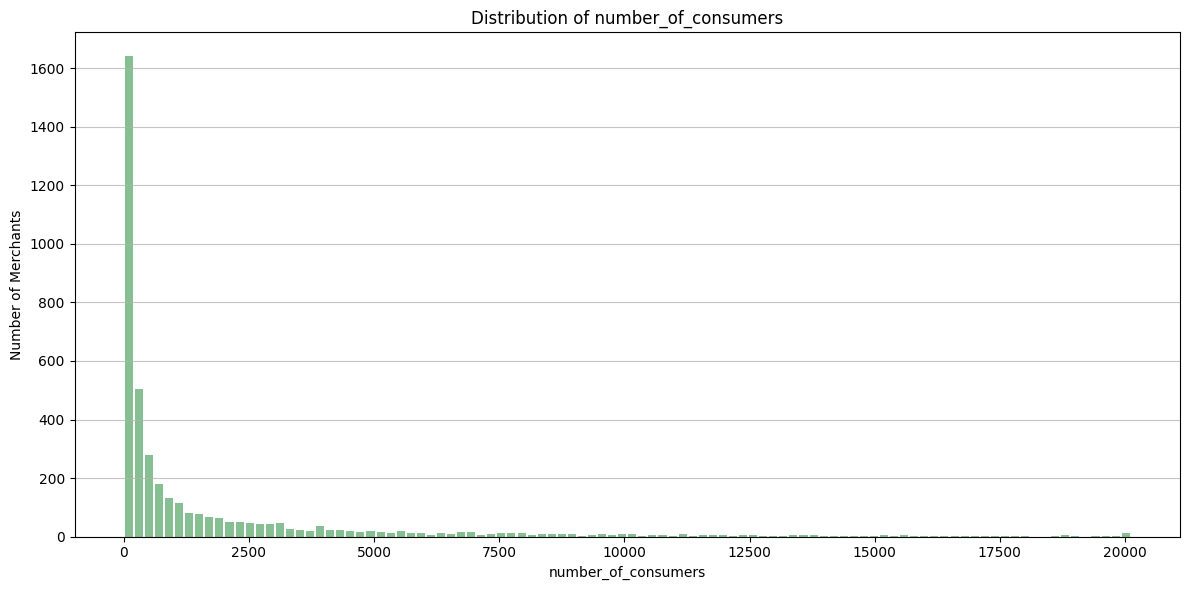

In [4]:
# List of columns to analyze
columns_to_analyze = [
    "average_consumer_fraud_probability", 
    "avg_median_age", 
    "avg_total_weekly_personal_income", 
    "take_rate", 
    "average_cost_of_order", 
    "number_of_orders", 
    "number_of_consumers"
]

# For each column, calculate summary statistics and plot the distribution
for column in columns_to_analyze:
    # Calculate Summary Statistics
    summary_stats = df_pandas[column].describe()
    print(f"Summary Statistics for {column}:\n")
    print(summary_stats)
    print("\n" + "-"*50 + "\n")

    # Plot Distribution
    plt.figure(figsize=(12, 6))
    plt.hist(df_pandas[column], bins=100, color='#86bf91', rwidth=0.8)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Number of Merchants')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()


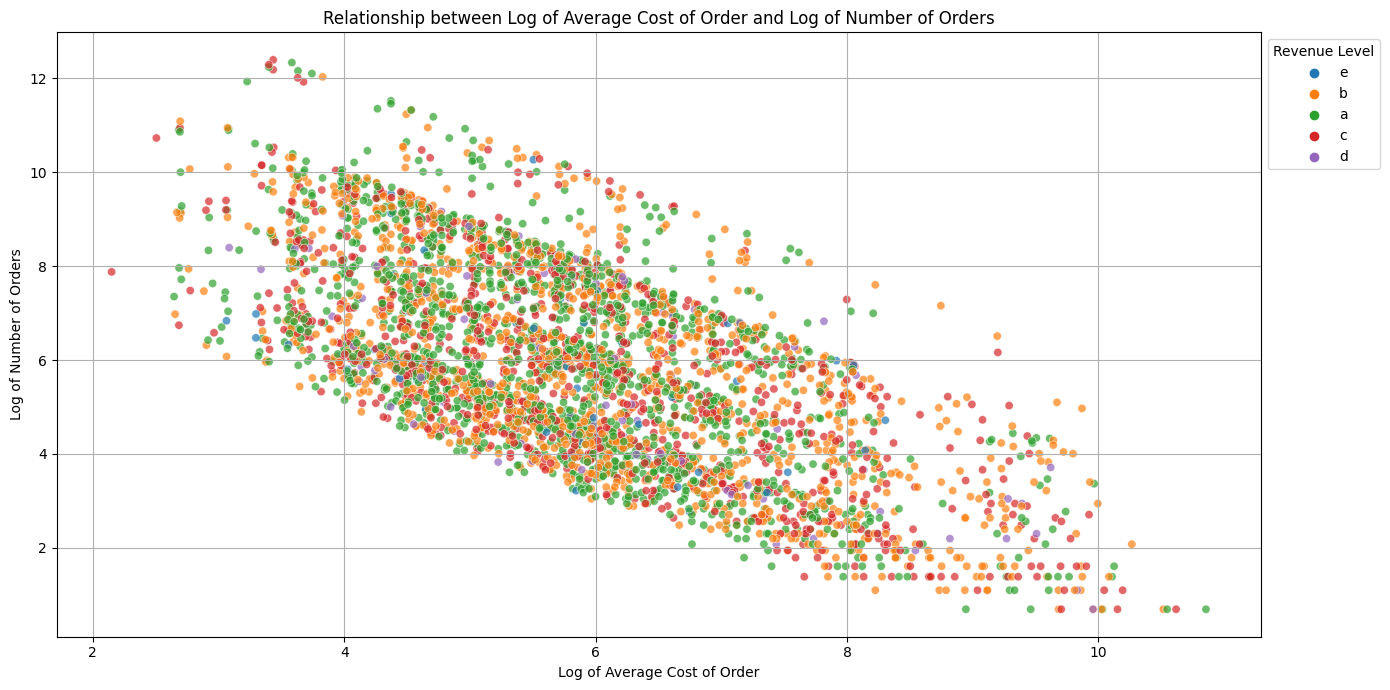

In [10]:
import seaborn as sns
from pyspark.sql.functions import log1p

df = df.withColumn('log_average_cost_of_order', log1p(df['average_cost_of_order']))
df = df.withColumn('log_number_of_orders', log1p(df['number_of_orders']))

# Convert the PySpark dataframe to a pandas dataframe for visualization
df_pandas = df.toPandas()

# Create the scatter plot with revenue_level as hue
plt.figure(figsize=(14, 7))
sns.scatterplot(data=df_pandas, x='log_average_cost_of_order', y='log_number_of_orders', hue='revenue_level', palette='tab10', alpha=0.7)
plt.title('Relationship between Log of Average Cost of Order and Log of Number of Orders')
plt.xlabel('Log of Average Cost of Order')
plt.ylabel('Log of Number of Orders')
plt.grid(True)
plt.legend(title='Revenue Level', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
